In [1]:
import warnings
warnings.filterwarnings('ignore')
    
import arviz as az
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
from gala.units import UnitSystem
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pymc3 as pm
import pymc3_ext as pmx
from tqdm.notebook import tqdm
import astropy.table as at
from aesara_theano_fallback import tensor as tt
import exoplanet.units as xu
import json
import corner
import pandas as pd

from yellowcard.model_pymc3 import TimingArgumentModelPymc3

In [2]:
plt.rcParams.update({"text.usetex":False,"font.size":16})

palette = {"fid": "#7B55F3",
           "fiducial2021": "#7B55F3",
           "vdmmod":'#FFB201',
           "Dataset3":'#FFB201',
           "vdm":"#DE2280",
           "vdm2012":"#DE2280"}

labels = {"vdm":r"vdMG08 Dist. + HST PM",
          "vdm2012":r"vdMG08 Dist. + HST PM",
          "vdmmod":r"Cepheid Dist. + HST PM",
          "Dataset3":r"Cepheid Dist. + HST PM",
          "fid":r"Cepheid Dist. + Gaia PM",
          "fiducial2021":r"Cepheid Dist. + Gaia PM"}

dataChoices = ["vdm2012","fiducial2021","Dataset3"]


In [3]:
usys = UnitSystem(1e12*u.Msun, u.kpc, u.Gyr, u.radian)

____
# Calculate medians - run this first

## Mass vs. vtravel

In [4]:
# --------------------- #
# get those means bby!! #
# --------------------- #
vtravels = np.arange(0,105,5)

meds_vtravel = {}
stds_vtravel = {}

meds_32 = {}
stds_32 = {}

for mod in dataChoices:
    meds_vtravel[mod]={}
    stds_vtravel[mod]={}
    Ms, rs, es, etas, alphas = [],[],[],[],[]
    Ms_stds, rs_stds, es_stds, etas_stds, alphas_stds = [],[],[],[],[]
    meds_vtravel[mod]['vtravel'] = vtravels
    stds_vtravel[mod]['vtravel'] = vtravels
    
    for vs in vtravels:
        data = az.from_json(f"../pymc3-data/{mod}_vtravel_{vs}.json")
        
        for param,arr,arr_stds in zip(["M","r","e","eta","alpha"],[Ms,rs,es,etas,alphas],[Ms_stds, rs_stds, es_stds, etas_stds, alphas_stds]):
            arr.append(np.asarray((data.posterior[param]).median()))
            arr_stds.append(np.asarray((data.posterior[param]).std()))
            
    for param,arr,arr_stds  in zip(["M","r","e","eta","alpha"],[Ms,rs,es,etas,alphas],[Ms_stds, rs_stds, es_stds, etas_stds, alphas_stds]):
        meds_vtravel[mod][param] = np.array(arr)
        stds_vtravel[mod][param] = np.array(arr_stds)
        
    # for the 32km/s run only:    
    meds_32[mod]={}
    stds_32[mod]={}
    Ms_32, rs_32, es_32, etas_32, alphas_32 = [],[],[],[],[]
    Ms_stds_32, rs_stds_32, es_stds_32, etas_stds_32, alphas_stds_32 = [],[],[],[],[]
    meds_32[mod]['vtravel'] = 32
    stds_32[mod]['vtravel'] = 32    
        
    data = az.from_json(f"../pymc3-data/{mod}_vtravel_32.json")
    for param,arr,arr_stds in zip(["M","r","e","eta","alpha"],[Ms_32,rs_32,es_32,etas_32,alphas_32],[Ms_stds_32, rs_stds_32, es_stds_32, etas_stds_32, alphas_stds_32]):
        arr.append(np.asarray((data.posterior[param]).median()))
        arr_stds.append(np.asarray((data.posterior[param]).std()))
            
    for param,arr,arr_stds  in zip(["M","r","e","eta","alpha"],[Ms_32,rs_32,es_32,etas_32,alphas_32],[Ms_stds_32, rs_stds_32, es_stds_32, etas_stds_32, alphas_stds_32]):
        meds_32[mod][param] = np.array(arr)
        stds_32[mod][param] = np.array(arr_stds)
    
        

## Mass error vs. pm error

In [5]:
# mass error as function of proper motion improvement
pm_errs = np.array([1,2,4,8,16])

meds_pmimprov = {}
stds_pmimprov = {}

for mod in dataChoices:
    meds_pmimprov[mod]={}
    stds_pmimprov[mod]={}
    Ms, rs, es, etas, alphas = [],[],[],[],[]
    Ms_stds, rs_stds, es_stds, etas_stds, alphas_stds = [],[],[],[],[]
    meds_pmimprov[mod]['pm_errs'] = pm_errs
    stds_pmimprov[mod]['pm_errs'] = pm_errs
    
    for improv in pm_errs:
        data = az.from_json(f"../pymc3-data/{mod}_pmimprov_{improv}.json")
        
        for param,arr,arr_stds in zip(["M","r","e","eta","alpha"],[Ms,rs,es,etas,alphas],[Ms_stds, rs_stds, es_stds, etas_stds, alphas_stds]):
            arr.append(np.asarray((data.posterior[param]).mean()))
            arr_stds.append(np.asarray((data.posterior[param]).std()))
            
    for param,arr,arr_stds  in zip(["M","r","e","eta","alpha"],[Ms,rs,es,etas,alphas],[Ms_stds, rs_stds, es_stds, etas_stds, alphas_stds]):
        meds_pmimprov[mod][param] = np.array(arr)
        stds_pmimprov[mod][param] = np.array(arr_stds)
                

In [6]:
meds_pmimprov['vdm2012']

{'pm_errs': array([ 1,  2,  4,  8, 16]),
 'M': array([4.07386811, 3.8905956 , 3.85081903, 3.83877495, 3.8379968 ]),
 'r': array([776.90965665, 778.39227428, 778.06087331, 777.54832041,
        778.04363954]),
 'e': array([0.89940584, 0.92933338, 0.93562382, 0.93707412, 0.93796988]),
 'eta': array([-2.13954375, -2.15157723, -2.15302432, -2.15292235, -2.15358739]),
 'alpha': array([0.44133523, 0.91923099, 1.52771694, 1.98790067, 2.15012979])}

___

# Calculate errorbars

In [8]:
model = ["vdm2012","fiducial2021","Dataset3"]
label = ["vdMG08 Dist. + HST PM","Cepheid Dist. + Gaia PM","Cepheid Dist. + HST PM"]
percentiles = {}
for i in range(3):
    data = az.from_json(f"../pymc3-data/{model[i]}_vtravel_32.json")
    m_lg_values = np.asarray(data.posterior['M']).ravel()
    print(f"{label[i]}: ",np.percentile(m_lg_values, [16, 50, 84]))
    percentiles[f"{model[i]}"] = np.percentile(m_lg_values, [16,50,84])

vdMG08 Dist. + HST PM:  [3.51757101 3.9831388  4.6095211 ]
Cepheid Dist. + Gaia PM:  [3.97169036 4.53537345 5.30998381]
Cepheid Dist. + HST PM:  [3.71363318 4.05377158 4.56875186]


___
# Plots

## Contour (Key Figure)

In [10]:
dataChoices = ["vdm2012",'Dataset3',"fiducial2021"]
Mrange = (1.5,7)
erange = (0.5,1)

penarrubia16low, penarrubia16high = [2.26, 3.06]
vdm12low, vdm12high = [3.74,4.8]

stacked = {}

for model in dataChoices:
    data = az.from_json(f"../pymc3-data/{model}_vtravel_32.json")
    stacked[model] = np.vstack([np.asarray(data.posterior[i]).ravel() for i in ["M","e"]])

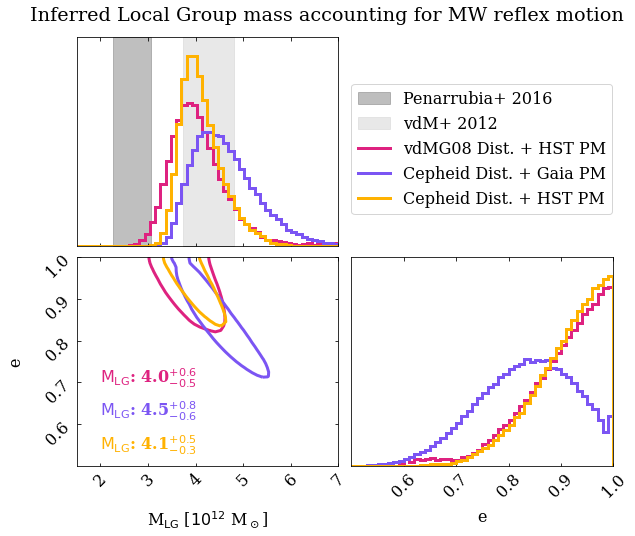

In [66]:
fig,ax = plt.subplots(2,2,figsize=(10,8))
# to create corner plot and add legends
for dat in dataChoices:
    corner.corner(stacked[dat].T,
                        labels=[r"M$_{\rm LG}$ [$10^{12}$ M$_\odot$]","e"],
                        plot_datapoints=False,
                        plot_density=False,
                        color=palette[dat],
                        linestyles='solid',
                        fig=fig,
                        levels=[0.68],
                        contour_kwargs={"linestyles":"solid","linewidths":3},
                        hist_kwargs={"linestyle":"solid","linewidth":3},
                        contourf_kwargs={"linestyles":"solid"},
                        range=[Mrange, erange],
                        bins=50,
                        smooth=1,
                  max_n_ticks=6
                  )
    plt.plot(0,0,
             lw=3,
             color=palette[dat],
             label=fr"{labels[dat]}")

# to set axes limits
ax[1][1].set_xlim(erange)
ax[1][0].set_ylim(erange)
for i in range(2):
    ax[i][0].set_xlim(Mrange)

# plot bands for range comparison
for row in range(1): # if needed shaded bands in lower left plot, change range to 2
    ylims = ax[row][0].get_ylim()
    ax[row][0].fill_betweenx(np.linspace(ylims[0],ylims[1]),
                             penarrubia16low, penarrubia16high,
                             color='grey',
                             alpha=0.5)
    ax[row][0].fill_betweenx(np.linspace(ylims[0],ylims[1]),
                             vdm12low, vdm12high,
                             color='lightgrey',
                             alpha=0.5)
    
# add shaded bands to legend
ax[0][0].fill_betweenx(np.linspace(ylims[0],ylims[0]),
                             vdm12low, vdm12high,
                             color='grey',
                             alpha=0.5,
                             label="Penarrubia+ 2016")
ax[0][0].fill_betweenx(np.linspace(ylims[0],ylims[0]),
                             vdm12low, vdm12high,
                             color='lightgrey',
                             alpha=0.5,
                             label="vdM+ 2012")  
yloc = [0.7,0.62,0.54]
hh = 0
for i in dataChoices:
    med = percentiles[i][1]
    hi = percentiles[i][2]-percentiles[i][1]
    lo = percentiles[i][1]-percentiles[i][0]
    ax[1][0].text(2, yloc[hh],
                  r"$\rm M_{\rm LG}$: %0.1f$^{+ %0.1f}_{-%.1f}$" % ( med, hi, lo),
                  color = palette[i],
                  fontweight ='bold')
    hh+=1

    
# to set x labels closer to plot
for i in range(2):
    ax[1][i].xaxis.set_label_coords(0.5, -0.2)
    ax[1][i].yaxis.set_label_coords(-0.2,0.5)

fig.legend(loc=(0.553,0.6))
fig.suptitle("Inferred Local Group mass accounting for MW reflex motion",x=0.53)
plt.savefig("../plots/analyze-runs-contour.pdf")
plt.show()


___
## Mass vs vtravel

In [11]:
meds_vtravel["vdm2012"]["vtravel"][-1]

100

In [12]:
# distance of tracers in the halo vs. "measured" travel velocity from Garavito-Camargo 2021
nico_data = [[60.09584664536741, 45.45454545454547],
 [80.03194888178913, 70.27972027972028],
[100.22364217252397, 83.56643356643357],
[120.1597444089457, 92.65734265734265]] # note this is dist vs. velocity

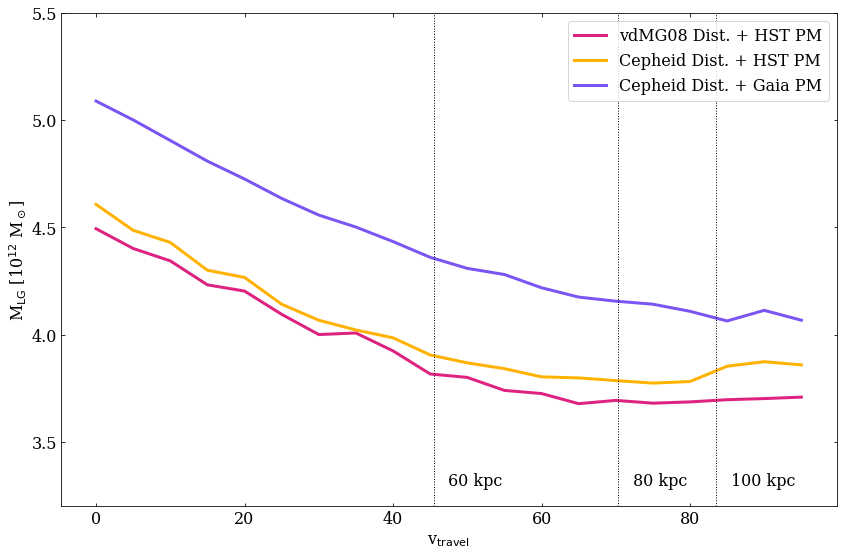

In [13]:
modelChoices = ["vdm2012","Dataset3","fiducial2021"]
label = [r"vdMG08 Dist. + HST PM",r"Cepheid Dist. + HST PM",r"Cepheid Dist. + Gaia PM"]
alpha = [0,1,2]

fig,ax=plt.subplots(figsize=(12,8))
for mod,al in zip(modelChoices,alpha):
    plt.plot(meds_vtravel[mod]['vtravel'][:-1], meds_vtravel[mod]['M'][:-1],
             label=labels[mod], color=palette[mod], lw=3)

# # to include 32km/s points and label in legend:    
# for mod,al in zip(modelChoices,alpha):
#     plt.errorbar(x=meds_32[mod]['vtravel']+al, 
#                  y=meds_32[mod]['M'],
#                  yerr=stds_32[mod]['M'],
#                  color=palette[mod],capsize=16,
#                  capthick=3,marker='^',ms=15)
# plt.scatter(0,0,label=r'v$_{\rm travel}$=32km/s (Petersen+ 2021)',marker="^",s=100,color='grey')

ax.set_xlabel(r'v$_{\rm travel}$')
ax.set_ylabel(r'M$_{\rm LG}$ [10$^{12}$ M$_\odot$]')
for i in range(len(nico_data))[0:-1]:
    plt.axvline(nico_data[i][1],color="black", linestyle="dotted", lw=1)
    plt.text(nico_data[i][1]+2, 3.3,"%.0f kpc" % nico_data[i][0])
    
plt.legend(loc="upper right")
plt.ylim(3.2,5.5)
plt.tight_layout()
plt.savefig("../plots/analyze-runs-MvsV.pdf")
plt.show()

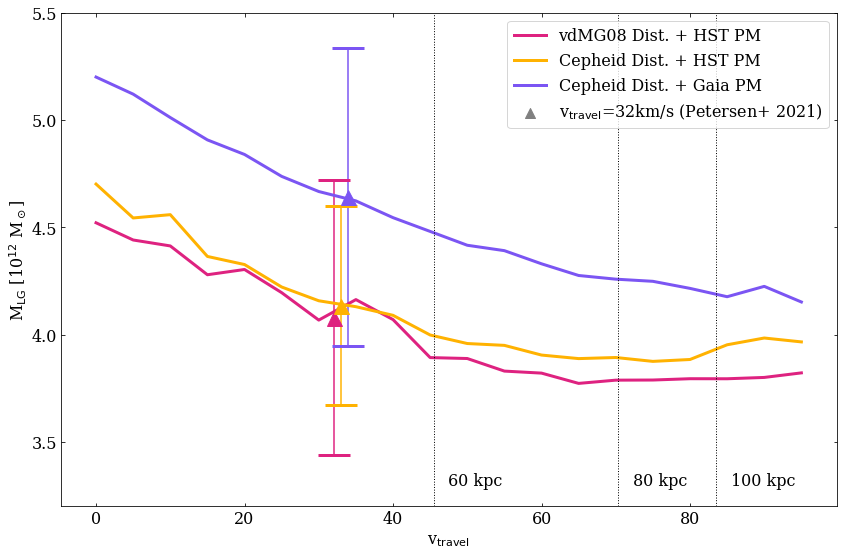

In [22]:
modelChoices = ["vdm2012","Dataset3","fiducial2021"]
label = [r"vdMG08 Dist. + HST PM",r"Cepheid Dist. + HST PM",r"Cepheid Dist. + Gaia PM"]
alpha = [0,1,2]

fig,ax=plt.subplots(figsize=(12,8))
for mod,al in zip(modelChoices,alpha):
    plt.plot(meds_vtravel[mod]['vtravel'][:-1], meds_vtravel[mod]['M'][:-1],
             label=labels[mod], color=palette[mod], lw=3)

for mod,al in zip(modelChoices,alpha):
    plt.errorbar(x=meds_32[mod]['vtravel']+al, 
                 y=meds_32[mod]['M'],
                 yerr=stds_32[mod]['M'],
                 color=palette[mod],capsize=16,
                 capthick=3,marker='^',ms=15)

plt.scatter(0,0,label=r'v$_{\rm travel}$=32km/s (Petersen+ 2021)',marker="^",s=100,color='grey')
ax.set_xlabel(r'v$_{\rm travel}$')
ax.set_ylabel(r'M$_{\rm LG}$ [10$^{12}$ M$_\odot$]')
for i in range(len(nico_data))[0:-1]:
    plt.axvline(nico_data[i][1],color="black", linestyle="dotted", lw=1)
    plt.text(nico_data[i][1]+2, 3.3,"%.0f kpc" % nico_data[i][0])
    
plt.legend(loc="upper right")
plt.ylim(3.2,5.5)
plt.tight_layout()
# plt.savefig("../plots/analyze-runs-MvsV.pdf")
plt.show()

___
## Mass vs vtravel

___
## Mass constraint vs. pm error

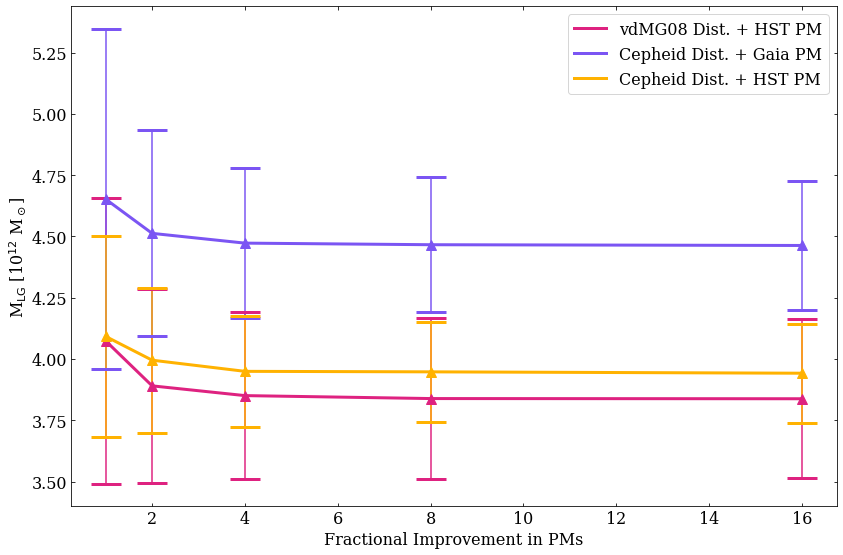

In [42]:
fig,ax=plt.subplots(figsize=(12,8))
for mod in modelChoices:
    plt.plot(meds_pmimprov[mod]['pm_errs'], meds_pmimprov[mod]['M'],
             label=labels[mod], color=palette[mod], lw=3)

for mod in modelChoices:
    plt.errorbar(x=meds_pmimprov[mod]['pm_errs'], 
                 y=meds_pmimprov[mod]['M'],
                 yerr=stds_pmimprov[mod]['M'],
                 color=palette[mod], capsize=15,
                 capthick=3, marker='^',ms=10,
                 linestyle="")

# plt.scatter(0,0,label=r'v$_{\rm travel}$ from P21',marker="^",s=80,color='grey')
ax.set_xlabel(r'Fractional Improvement in PMs')
ax.set_ylabel(r'M$_{\rm LG}$ [10$^{12}$ M$_\odot$]')
plt.legend()
# plt.ylim(3.2,5.5)
plt.tight_layout()
# plt.savefig("../plots/analyze-runs-MvsPM.png",dpi=300)
plt.show()

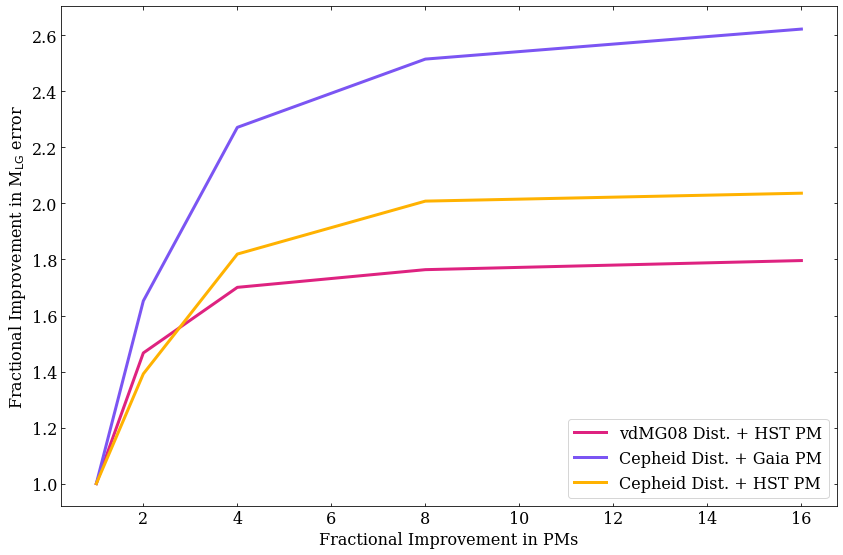

In [47]:
fig,ax=plt.subplots(figsize=(12,8))
for mod in modelChoices:
    
    plt.plot(meds_pmimprov[mod]['pm_errs'], (stds_pmimprov[mod]['M']/stds_pmimprov[mod]['M'][0])**-1,
             label=labels[mod], color=palette[mod], lw=3)

ax.set_xlabel(r'Fractional Improvement in PMs')
ax.set_ylabel(r'Fractional Improvement in M$_{\rm LG}$ error')
plt.legend()
plt.tight_layout()
plt.savefig("../plots/analyze-runs-deltaMvsPM.pdf")
plt.show()

## Corner plots

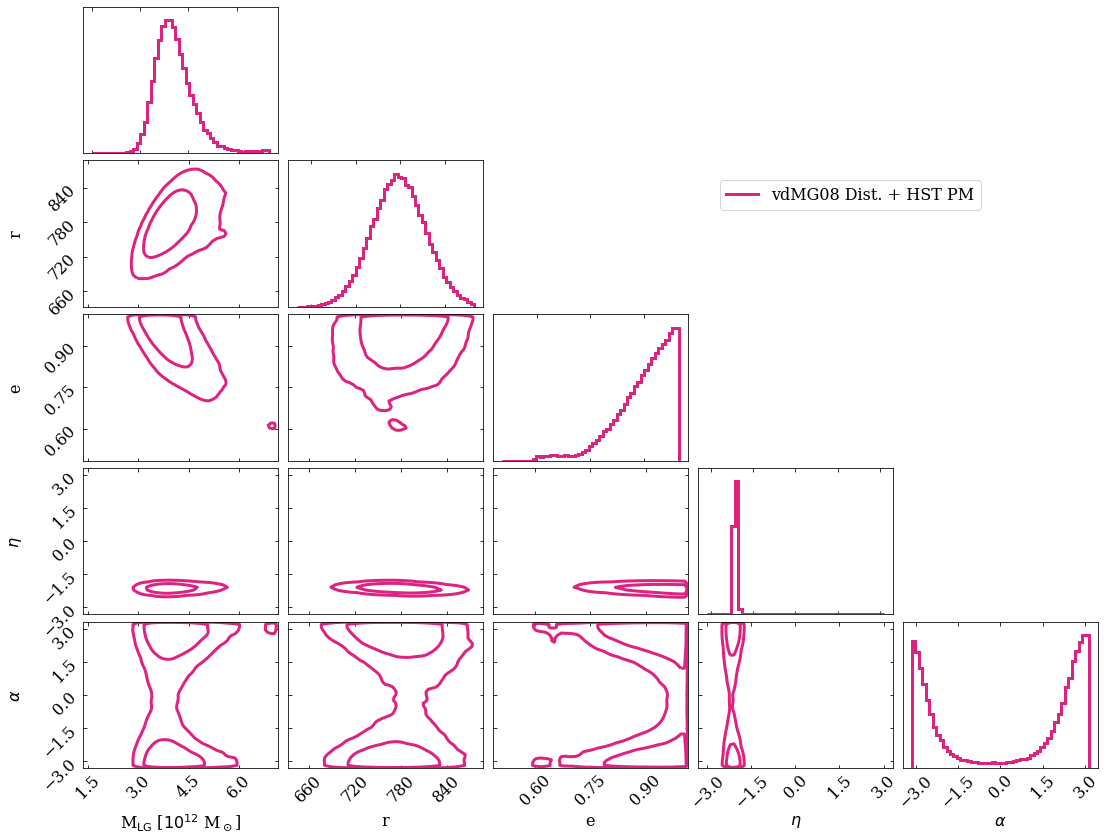

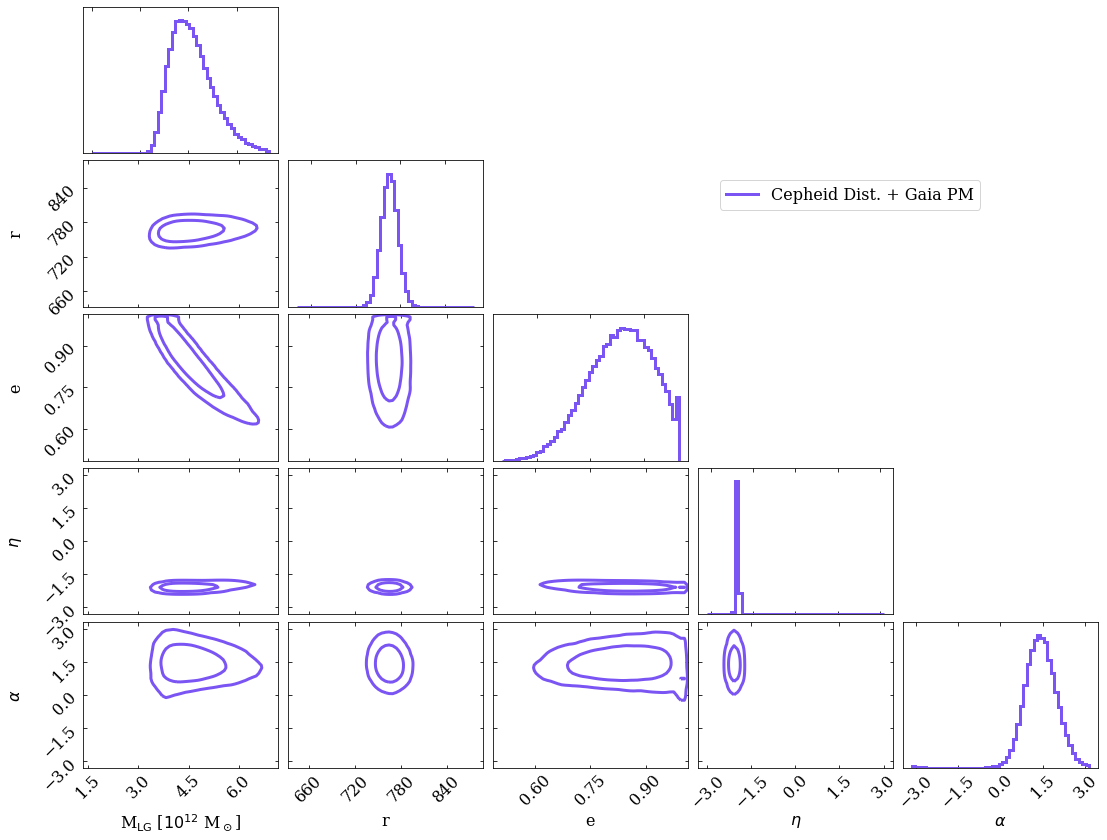

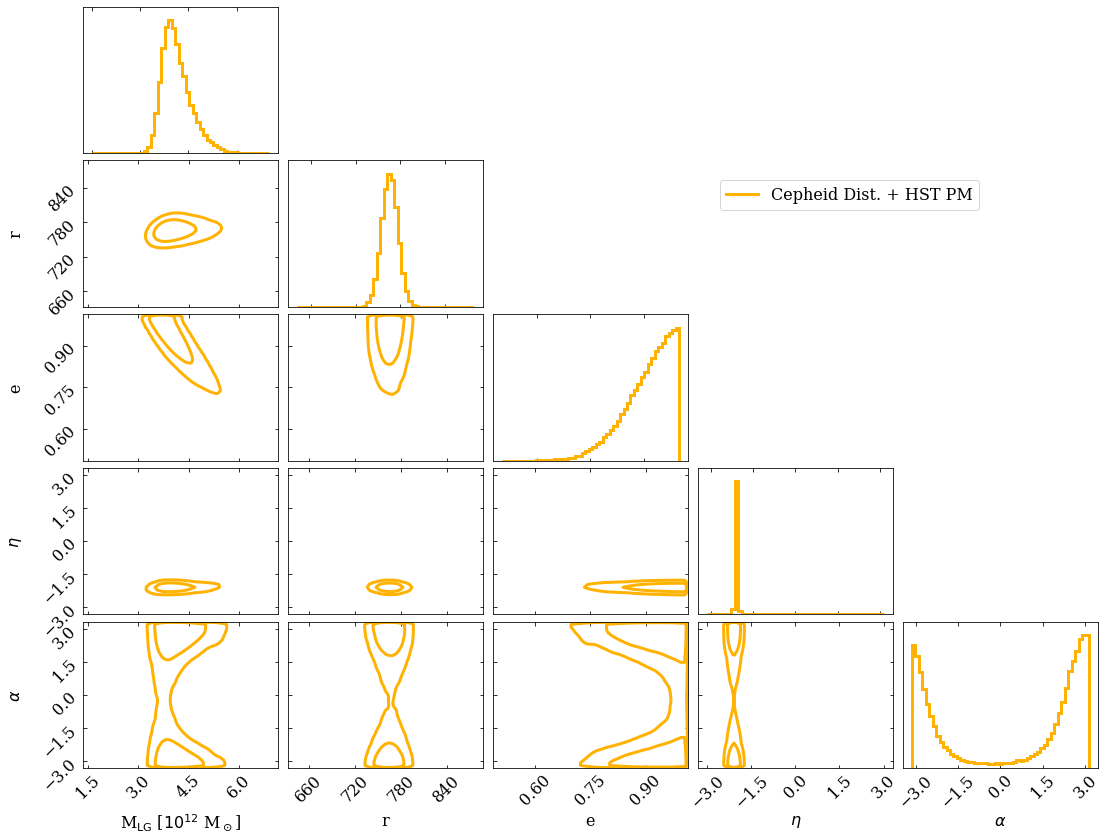

In [52]:
for dataset in modelChoices:
    label = labels[dataset]
    fig = plt.figure(figsize=(16,12))

    data = az.from_json(f"../pymc3-data/{dataset}_vtravel_32.json")
    howdy = np.vstack([np.asarray(data.posterior[i]).ravel() for i in ["M","r","e","eta","alpha"]])
    corner.corner(howdy.T,
                    labels=[r"M$_{\rm LG}$ [$10^{12}$ M$_\odot$]","r","e",r"$\eta$",r"$\alpha$"],
                    plot_datapoints=False,
                    plot_density=False,
                    color=palette[dataset],
                    linestyles="solid",
                    lw = 3,
                    fig=fig,
                    levels=[0.68, 0.95],
                    contour_kwargs={"linewidths":3},
                    hist_kwargs={"linewidth":3},
                    contourf_kwargs={"linestyles":3},
                    range=[(1.5,7), (640,880), (0.5,1),(-np.pi,np.pi),(-np.pi,np.pi)],
                    smooth=1,
                    bins=51
                 );
    plt.plot(0,0,lw=3,color=palette[dataset],label=labels[dataset])
    fig.legend(loc=(0.65,0.75))
    plt.savefig(f"../plots/analyze-runs-all-{dataset}.pdf")
    plt.show()





## All params vs. vtravel

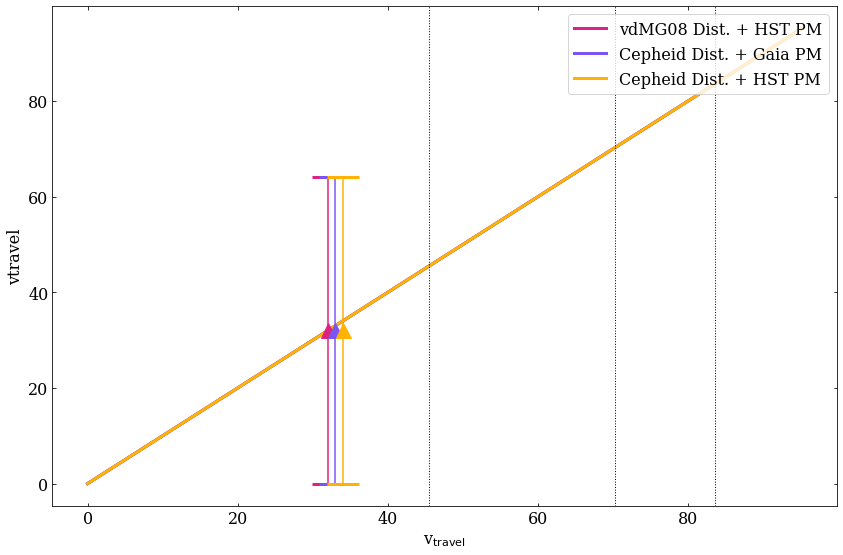

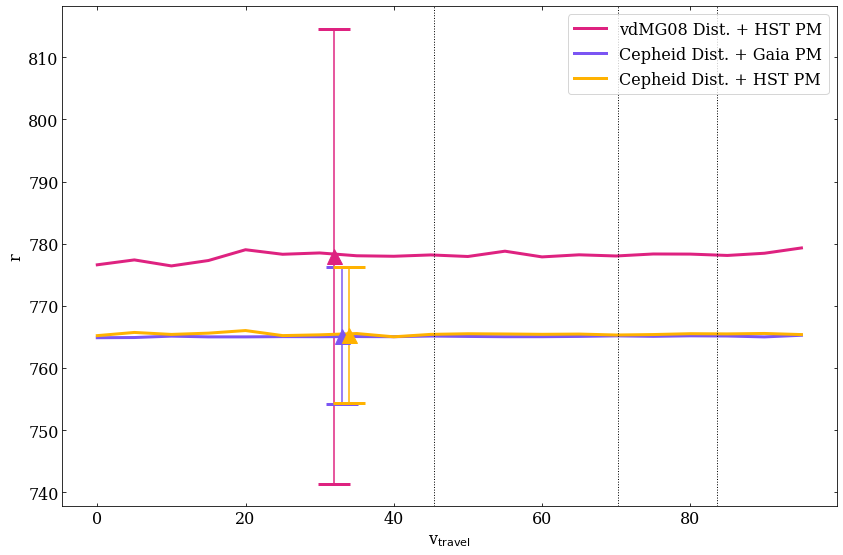

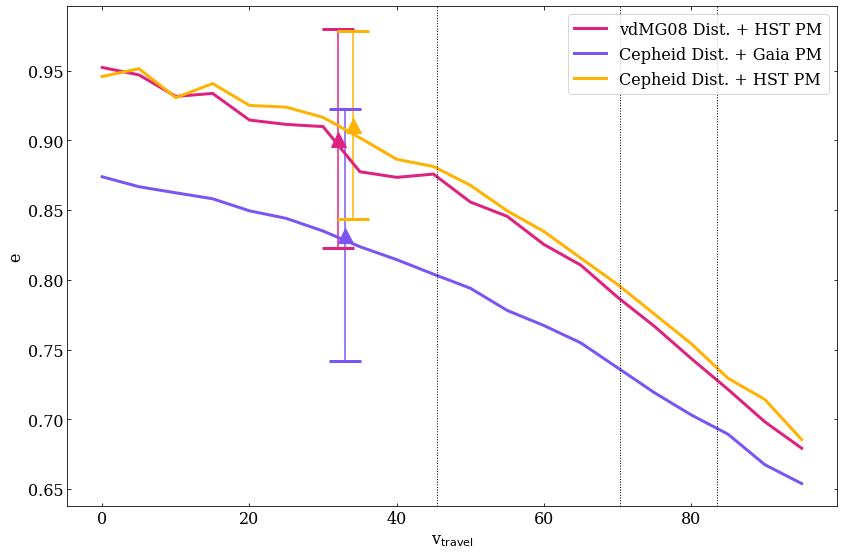

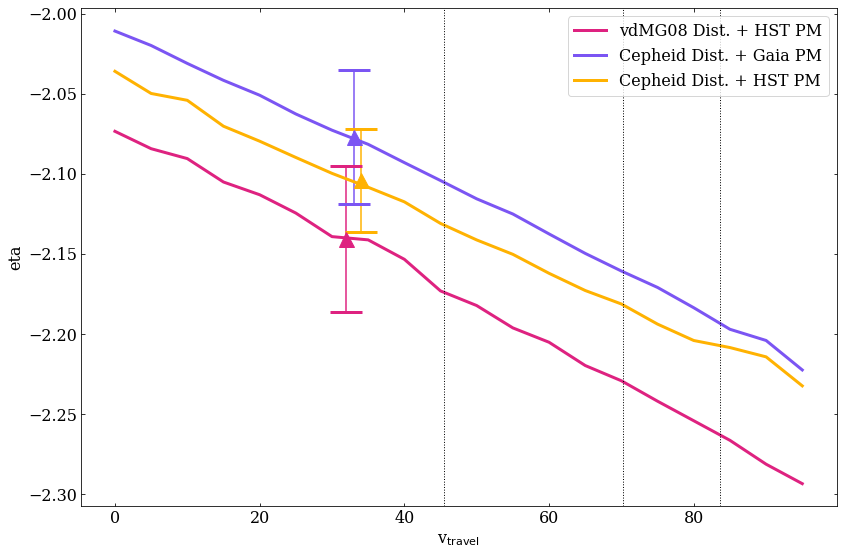

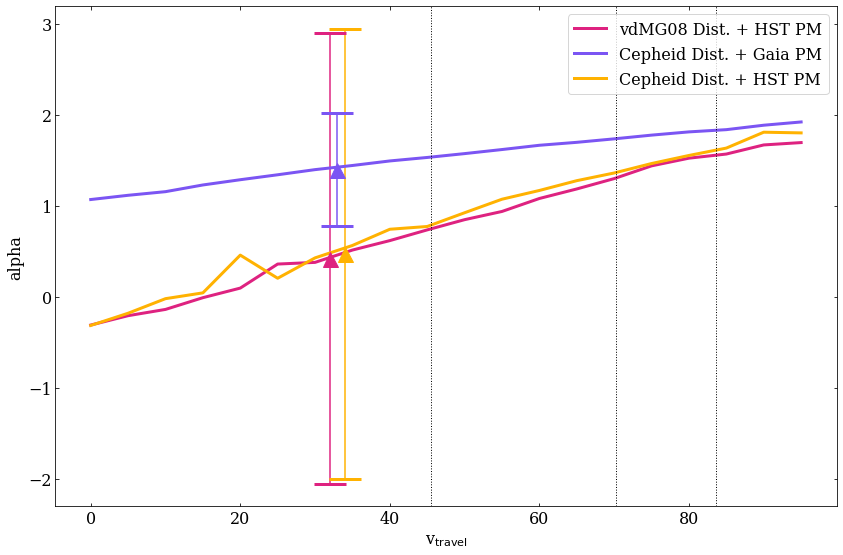

In [35]:
for i in meds_vtravel['fiducial2021'].keys():
    if i == "M":
        continue
    alpha = [0,1,2]

    fig,ax=plt.subplots(figsize=(12,8))
    for mod,al in zip(modelChoices,alpha):
        plt.plot(meds_vtravel[mod]['vtravel'][:-1], meds_vtravel[mod][i][:-1],
                 label=labels[mod], color=palette[mod], lw=3)

    for mod,al in zip(modelChoices,alpha):
        plt.errorbar(x=meds_32[mod]['vtravel']+al, 
                     y=meds_32[mod][i],
                     yerr=stds_32[mod][i],
                     color=palette[mod],capsize=16,
                     capthick=3,marker='^',ms=15)

#     plt.scatter(0,0,label=r'v$_{\rm travel}$=32km/s (Petersen+ 2021)',marker="^",s=0,color='grey')
    ax.set_xlabel(r'v$_{\rm travel}$')
    ax.set_ylabel(f'{i}')
    for j in range(len(nico_data))[0:-1]:
        plt.axvline(nico_data[j][1],color="black", linestyle="dotted", lw=1)
#         plt.text(nico_data[j][1]+2, ,"%.0f kpc" % nico_data[j][0])
    plt.legend(loc="upper right")
    plt.savefig(f"../plots/analyze-runs-{i}vsV.pdf")
    plt.tight_layout()
    plt.show()

---

___

# Graveyard

## Measured vtravel

In [ ]:
# vtravels_meas = np.array([0,32])
# meds_vtravel_meas = {}
# stds_vtravel_meas = {}

# for mod in modelChoices:
#     meds_vtravel_meas[mod]={}
#     stds_vtravel_meas[mod]={}
#     Ms, rs, es = [],[],[]
#     Ms_stds, rs_stds, es_stds = [],[],[]
#     meds_vtravel_meas[mod]['vtravel'] = vtravels_meas
#     stds_vtravel_meas[mod]['vtravel'] = vtravels_meas
    
#     for vs in vtravels_meas:
#         data = az.from_json(f"../pymc3-data/{mod}_vtravel_{vs}.json")

#         for param,arr,arr_stds in zip(["M","r","e"],[Ms,rs,es],[Ms_stds, rs_stds, es_stds]):
#             arr.append(np.asarray((data.posterior[param]).mean()))
#             arr_stds.append(np.asarray((data.posterior[param]).std()))

#         for param,arr,arr_stds  in zip(["M","r","e"],[Ms,rs,es],[Ms_stds, rs_stds, es_stds]):
#             meds_vtravel_meas[mod][param] = np.array(arr)
#             stds_vtravel_meas[mod][param] = np.array(arr_stds)

In [ ]:
# meds_vtravel_meas['fiducial2021']

In [ ]:
# stds_vtravel_meas['fiducial2021']

In [ ]:
# model comparison where v_t = 0 is in grey

dataChoices = ["vdm2012",'Dataset3',"fiducial2021"]
label = [r"vdMG08 Dist. + HST PM",r"Cepheid Dist. + HST PM",r"Cepheid Dist. + Gaia PM"]

include_vTravel = ["0","32"]
color = ["Grey","Grey","Grey",palette['Extra'],palette['Minor Pairs'],palette['Major Pairs']]
# color = ["white","white","white","white"]
# color = ["white","white",palette['Minor Pairs'],palette["Extra"]]
style = ['dotted','dotted','dotted','solid','solid','solid']
widths = [2,2,2,3,3,3]
model=[ "Old model","Old model","Our model", "Our model","hey","sup"]


i=0
fig = plt.figure(figsize=(10,8))
for incl in include_vTravel:
    for dat,name in zip(dataChoices,label_model):

        # uncomment if running for just dotted contours:
#         if incl != "0":
#             i+=1
#             continue
        print(incl, dat, name,style[i], "is color", color[i])
        data = az.from_json(f"../pymc3-data/{dat}_vtravel_{incl}.json")
        howdy = np.vstack([np.asarray(data.posterior[i]).ravel() for i in ["M","r","e"]])
        howdy = np.vstack([np.asarray(data.posterior[i]).ravel() for i in ["M","e"]])
        corner.corner(howdy.T,
                            labels=[r"M$_{\rm LG}$ [$10^{12}$ M$_\odot$]","e"],
                            plot_datapoints=False,
                            plot_density=False,
                            color=color[i],
                            linestyles=style[i],
                            fig=fig,
                            levels=[ 0.95],
                            contour_kwargs={"linestyles":style[i],"linewidths":widths[i]},
                            hist_kwargs={"linestyle":style[i],"linewidth":widths[i]},
                            contourf_kwargs={"linestyles":style[i]},
#                             range=[(2.9,7.5), (640,880), (0.56,1)]
                     );
        i+=1
        
# fig.savefig(f'../plots/analyze-runs-contour.png',dpi=300)

# plt.plot(0,0,lw=3,color=palette["Major Pairs"],label=r"Cepheids+HST")
# plt.plot(0,0,lw=3,color=palette["Minor Pairs"],label="Gaia+Cepheids")
# plt.plot(0,0,lw=3,color=palette["Extra"],label="HST")
plt.plot(0,0,lw=2,color="gray",linestyle="dotted",label=r"v$_{\rm travel} = 0$")
for gojo in range(3):
    plt.plot(0,0,
             lw=3,
             color=color[gojo],
             label=fr"{label[gojo]}")

for row in range(2):
    ylims = ax[row][0].get_ylim()
    ax[row][0].fill_betweenx(np.linspace(ylims[0],ylims[1]),
                             penarrubia16low, penarrubia16high,
                             color='grey',
                             alpha=0.5)
    ax[row][0].fill_betweenx(np.linspace(ylims[0],ylims[1]),
                             vdm12low, vdm12high,
                             color='lightgrey',
                             alpha=0.5)

fig.legend(loc=(0.65,0.75))
# plt.savefig("../plots/analyze-runs-contour.png",dpi=300)
# plt.savefig("../plots/analyze-runs-contour.png",dpi=300)
# plt.savefig("../plots/analyze-runs-contour_dotted.png",dpi=300)
# plt.savefig("../plots/analyze-runs-contour_white.png",dpi=300)
plt.show()





In [ ]:
# modelChoices = ["vdm2012","fiducial2021"]
# label_model = ["Chamberlain+ 2021", "van der Marel+ 2012"]
# include_vTravel = ["0","32"]
# color = ["Grey","Grey",palette['Minor Pairs'],palette['Minor Pairs']]
# # color = ["white","white","white","white"]
# # color = ["white","white",palette['Minor Pairs'],palette["Extra"]]
# style = ['solid','dotted','solid','dotted']
# widths = [2,2,3,3]
# model=[ "Old model","Old model","Our model", "Our model"]


# i=0
# fig = plt.figure(figsize=(10,8))
# for incl in include_vTravel:
#     for mod,name in zip(modelChoices,label_model):

#         # uncomment if running for just dotted contours:
# #         if incl != "0":
# #             i+=1
# #             continue
#         print(incl, mod, name,style[i], "is color", color[i])
#         data = az.from_json(f"../pymc3-data/{mod}_vtravel_{incl}.json")
#         howdy = np.vstack([np.asarray(data.posterior[i]).ravel() for i in ["M","r","e"]])
#         corner.corner(howdy.T,
#                             labels=[r"M$_{\rm LG}$ [$10^{12}$ M$_\odot$]","r [kpc]","e"],
#                             plot_datapoints=False,
#                             plot_density=False,
#                             color=color[i],
#                             linestyles=style[i],
#                             fig=fig,
#                             levels=[ 0.95],
#                             contour_kwargs={"linestyles":style[i],"linewidths":widths[i]},
#                             hist_kwargs={"linestyle":style[i],"linewidth":widths[i]},
#                             contourf_kwargs={"linestyles":style[i]},
# #                             range=[(2.9,7.5), (640,880), (0.56,1)]
#                      );
#         i+=1
        
# fig.savefig(f'../plots/analyze-runs-contour.png',dpi=300)

# plt.plot(0,0,lw=3,color=palette["Minor Pairs"],label=r"Chamberlain et. al 2021")
# plt.plot(0,0,lw=2,color="grey",linestyle="solid",label=r"v$_{\rm travel} = 0$")
# plt.plot(0,0,lw=3,color="gray",linestyle="solid",label="Dataset 1")
# plt.plot(0,0,lw=3,color="gray",linestyle="dashed",label="Dataset 2")
# fig.legend(loc=(0.55,0.75))
# # plt.savefig("../plots/analyze-runs-contour.png",dpi=300)
# # plt.savefig("../plots/analyze-runs-contour_dotted.png",dpi=300)
# # plt.savefig("../plots/analyze-runs-contour_white.png",dpi=300)
# plt.show()





In [ ]:
# modelChoices = ["vdm2012","fiducial2021"]
# label_model = ["van der Marel+ 2012","Chamberlain+ 2021"]
# include_vTravel = ["32","0"]
# color = [palette['Minor Pairs'],palette["Extra"],palette['Minor Pairs'],palette["Extra"]]
# # color = ["white","white","white","white"]
# # color = ["white","white",palette['Minor Pairs'],palette["Extra"]]
# style = ['solid','solid','dotted','dotted']
# widths = [2,2,3,3]


# i=0
# fig = plt.figure(figsize=(10,8))
# for incl in include_vTravel:
#     for mod,name in zip(modelChoices,label_model):
    
#         # uncomment if running for just dotted contours:
# #         if incl != "0":
# #             i+=1
# #             continue
#         print(incl, mod, name,style[i])
#         data = az.from_json(f"../pymc3-data/{mod}_vtravel_{incl}.json")
#         howdy = np.vstack([np.asarray(data.posterior[i]).ravel() for i in ["M","r","e"]])
#         corner.corner(howdy.T,
#                         labels=[r"M$_{\rm LG}$ [$10^{12}$ M$_\odot$]","r [kpc]","e"],
#                         plot_datapoints=False,
#                         plot_density=False,
#                         color=color[i],
#                         linestyles=style[i],
#                         fig=fig,
#                         levels=[0.95],
#                         contour_kwargs={"linestyles":style[i],"linewidths":widths[i]},
#                         hist_kwargs={"linestyle":style[i],"linewidth":widths[i]},
#                         contourf_kwargs={"linestyles":style[i]},
# #                             range=[(2.9,7.5), (640,880), (0.56,1)]
#                      );
#         i+=1
# fig.savefig(f'../plots/analyze-runs-contour.png',dpi=300)
# plt.plot(0,0,lw=3,color=color[2],label="Dataset 1")
# plt.plot(0,0,lw=3,color=color[3],label="Dataset 2")
# plt.plot(0,0,lw=3,color="grey",label=r"Chamberlain et al. 2021")
# plt.plot(0,0,lw=3,color="grey",linestyle="dotted",label=r"v$_{\rm travel} = 0$")
# plt.arrow(0.5,0.5,-1,-0.5)
# fig.legend(loc=(0.55,0.75))
# plt.savefig("../plots/analyze-runs-contour.png",dpi=300)
# # plt.savefig("../plots/analyze-runs-contour_dotted.png",dpi=300)
# # plt.savefig("../plots/analyze-runs-contour_white.png",dpi=300)
# plt.show()



